In [75]:
import numpy as np
import pandas as pd
from time import gmtime, strftime
import gc
import numpy as np
import sklearn
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from tqdm import tqdm
from sklearn.metrics import (roc_curve, auc, accuracy_score)
from lightgbm import LGBMClassifier,plot_importance
import os
import sys
import re
import warnings
warnings.filterwarnings(action='ignore')

In [76]:
cust2345 = pd.read_csv('customer_df_2345_final2.csv')
cust67 = pd.read_csv('customer_df_67_final2.csv')

In [77]:
cust67.columns

Index(['sex_clsf_cd', 'age_cd', 'total_prchs_cnt', 'weekend_prchs_cnt',
       'total_payment_amt', 'total_cpt_amt', 'total_prod_amt', 'pref_tm',
       'dly_prchs_amt_max', 'dly_prchs_amt_min', 'mly_prchs_amt_min',
       'mly_prchs_amt_max', 'mly_prchs_amt_mean', 'wly_prchs_amt_max',
       'wly_prchs_amt_min', 'wly_prchs_amt_mean', 'frequency', 'recency', 'T',
       'dt_step_min', 'dt_step_max', 'dt_step_mean', 'bin_count',
       'pref_category_eBook', 'pref_category_만화', 'pref_category_오디오북',
       'pref_category_웹소설', 'pref_category_웹툰', 'pref_category_정액제',
       'mno_cd_US001201', 'mno_cd_US001202', 'mno_cd_US001203',
       'mno_cd_US001205', 'mno_cd_US001206', 'mno_cd_US001208',
       'mno_cd_US001209', 'mno_cd_US001210', 'cluster_label_0',
       'cluster_label_1', 'cluster_label_2'],
      dtype='object')

In [78]:
df2345 = pd.read_csv('customer_df_2345_final2.csv')
df67 = pd.read_csv('customer_df_67_final2.csv')

# 표준편차 기반 예제 코드
def std_based_outlier(df):
    for i in range(0, len(df.iloc[1])):
        df.iloc[:,i] = df.iloc[:,i].replace(0, np.NaN)
        df = df[~(np.abs(df.iloc[:,i] - df.iloc[:,i].mean()) > (3*df.iloc[:,i].std()))].fillna(0)
    return(df)



from scipy.stats import ttest_ind
 
# Device group into two based on target
gr0 = df2345[df2345['bin_count'] == 0]
gr1 = df2345[df2345['bin_count'] == 1]
 
# Run test by each columns
for i in range(0, 40):
    var1 = gr0.iloc[:,i]
    var2 = gr1.iloc[:,i]
    print(ttest_ind(var1, var2))

def std_based_outlier(df):
    for i in range(0, len(df.iloc[1])):
        df.iloc[:,i] = df.iloc[:,i].replace(0, np.NaN)
        df = df[~(np.abs(df.iloc[:,i] - df.iloc[:,i].mean()) > (3*df.iloc[:,i].std()))].fillna(0)
    return(df)



Ttest_indResult(statistic=55.60969958592205, pvalue=0.0)
Ttest_indResult(statistic=-6.005500768261309, pvalue=1.913215366022761e-09)
Ttest_indResult(statistic=-47.426529880403464, pvalue=0.0)
Ttest_indResult(statistic=-47.079921424882386, pvalue=0.0)
Ttest_indResult(statistic=-162.32681862259997, pvalue=0.0)
Ttest_indResult(statistic=-90.39268079374139, pvalue=0.0)
Ttest_indResult(statistic=-175.44584412361485, pvalue=0.0)
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=-160.89597823063747, pvalue=0.0)
Ttest_indResult(statistic=-44.171191038225274, pvalue=0.0)
Ttest_indResult(statistic=-136.5048805070338, pvalue=0.0)
Ttest_indResult(statistic=-156.92505279536795, pvalue=0.0)
Ttest_indResult(statistic=-156.85241907765644, pvalue=0.0)
Ttest_indResult(statistic=-154.73607886219295, pvalue=0.0)
Ttest_indResult(statistic=-81.43039012137965, pvalue=0.0)
Ttest_indResult(statistic=-151.85117203655895, pvalue=0.0)
Ttest_indResult(statistic=-73.1190677603843, pvalue=0.0)
Tte

In [86]:
cust2345 = cust2345.rename(columns={'pref_category_만화':'pref_category_cartoon', 'pref_category_오디오북':'pref_category_audio',
       'pref_category_웹소설':'pref_category_web', 'pref_category_웹툰':'pref_category_webtoon', 'pref_category_정액제':'pref_category_sub'})
cust67 =  cust67.rename(columns={'pref_category_만화':'pref_category_cartoon', 'pref_category_오디오북':'pref_category_audio',
       'pref_category_웹소설':'pref_category_web', 'pref_category_웹툰':'pref_category_webtoon', 'pref_category_정액제':'pref_category_sub'})

In [87]:
X_train= cust2345.drop(['bin_count'], axis=1)
Y_train = cust2345['bin_count']

X_test = cust67.drop(['bin_count'], axis=1)
Y_test = cust67['bin_count']

In [88]:
def get_clf_eval(y_test, pred=None, pred_proba = None):
    confusion = confusion_matrix(Y_test, pred)
    accuracy = accuracy_score(Y_test, pred)
    precision = precision_score(Y_test, pred)
    recall = recall_score(Y_test, pred)
    f1 = f1_score(Y_test, pred)
    
    roc_auc = roc_auc_score(Y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))

In [89]:
def roc_curve_plot(y_test, pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba)
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR(1 - Sensitivity)'); plt.ylabel('TPR( Recall )')
    plt.legend()
    


In [90]:
def precision_recall_curve_plot(y_test, pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

In [91]:
# X_train, X_test, Y_train, Y_test = train_test_split(cust2345, cust2345['bin_count'], test_size=0.25, random_state=1,stratify = cust2345['bin_count'])
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=1,stratify = Y_train)


In [92]:
def Lgbm(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred


model = lgb.LGBMClassifier()
param_grid = {
    'n_estimators': [100, 200],
    'colsample_bytree': [0.8],
    'max_depth': [10,15],
    'num_leaves': [50,100],
    'reg_alpha': [1.1, 1.2],
    'reg_lambda': [1.1, 1.2],
    'min_split_gain': [0.3],
    'subsample': [0.7, 0.8],
    'subsample_freq': [20]
}

model, pred= Lgbm(X_train, X_test, Y_train, Y_test, model, 
                                 param_grid, cv=4, scoring_fit='accuracy')

print(model.best_score_)
print(model.best_params_)

Fitting 4 folds for each of 64 candidates, totalling 256 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  2.6min finished


0.8552633041998075
{'colsample_bytree': 0.8, 'max_depth': 10, 'min_split_gain': 0.3, 'n_estimators': 100, 'num_leaves': 100, 'reg_alpha': 1.2, 'reg_lambda': 1.2, 'subsample': 0.7, 'subsample_freq': 20}


In [93]:

print('Best parameters found by grid search are:', model.best_params_)


pred_test_rf_grid = model.predict(X_test)
print(f'accuracy: {accuracy_score(Y_test, pred_test_rf_grid)}')


Best parameters found by grid search are: {'colsample_bytree': 0.8, 'max_depth': 10, 'min_split_gain': 0.3, 'n_estimators': 100, 'num_leaves': 100, 'reg_alpha': 1.2, 'reg_lambda': 1.2, 'subsample': 0.7, 'subsample_freq': 20}
accuracy: 0.8622375451743787


In [94]:
grid_clf=GridSearchCV(model, param_grid=param_grid,scoring='accuracy',cv=4)
print('Best score reached: {} with params: {} '.format(model.best_score_, model.best_params_))

scores_df = pd.DataFrame(model.cv_results_)
scores_df[['params','mean_test_score','rank_test_score','split0_test_score','split1_test_score','split2_test_score','split3_test_score']]

Best score reached: 0.8552633041998075 with params: {'colsample_bytree': 0.8, 'max_depth': 10, 'min_split_gain': 0.3, 'n_estimators': 100, 'num_leaves': 100, 'reg_alpha': 1.2, 'reg_lambda': 1.2, 'subsample': 0.7, 'subsample_freq': 20} 


,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score
0,"{'colsample_bytree': 0.8, 'max_depth': 10, 'mi...",0.854037,35,0.856126,0.856409,0.851740,0.851875
1,"{'colsample_bytree': 0.8, 'max_depth': 10, 'mi...",0.854002,36,0.856974,0.853956,0.853060,0.852016
2,"{'colsample_bytree': 0.8, 'max_depth': 10, 'mi...",0.854497,18,0.856314,0.857493,0.851551,0.852629
3,"{'colsample_bytree': 0.8, 'max_depth': 10, 'mi...",0.853259,60,0.856361,0.854381,0.851410,0.850884
4,"{'colsample_bytree': 0.8, 'max_depth': 10, 'mi...",0.854509,16,0.856078,0.856503,0.852636,0.852818
...,...,...,...,...,...,...,...
59,"{'colsample_bytree': 0.8, 'max_depth': 15, 'mi...",0.853294,59,0.856173,0.857069,0.848958,0.850979
60,"{'colsample_bytree': 0.8, 'max_depth': 15, 'mi...",0.852693,64,0.856503,0.855041,0.848958,0.850271
61,"{'colsample_bytree': 0.8, 'max_depth': 15, 'mi...",0.853601,50,0.857776,0.856644,0.850184,0.849800
62,"{'colsample_bytree': 0.8, 'max_depth': 15, 'mi...",0.854179,31,0.856361,0.856927,0.849429,0.853997


# training model
training accuracy: 0.8842
[[50043  4416]
 [ 5407 24957]]
# validation model
validation accuracy: 0.8560
[[16255  1899]
 [ 2173  7948]]
# test model
test accuracy: 0.8622
[[56101  6455]
 [ 5972 21678]]
 #train VS val
test accuracy: 0.8622
[[56101  6455]
 [ 5972 21678]]
 #train VS val
# train VS test
오차 행렬
[[56101  6455]
 [ 5972 21678]]
정확도: 0.8622, 정밀도: 0.7706, 재현율: 0.7840, F1: 0.7772, AUC: 0.9326


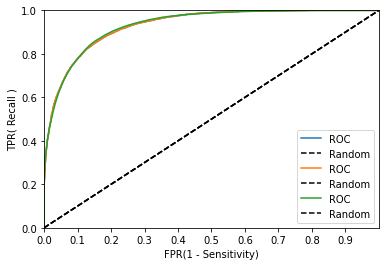

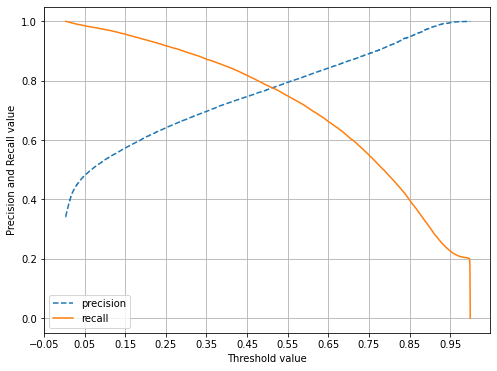

# train VS test
오차 행렬
[[56101  6455]
 [ 5972 21678]]
정확도: 0.8622, 정밀도: 0.7706, 재현율: 0.7840, F1: 0.7772, AUC: 0.9326


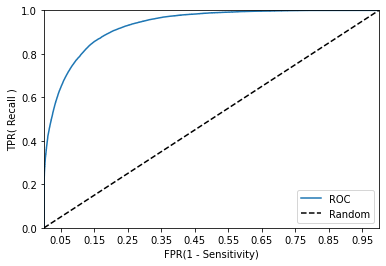

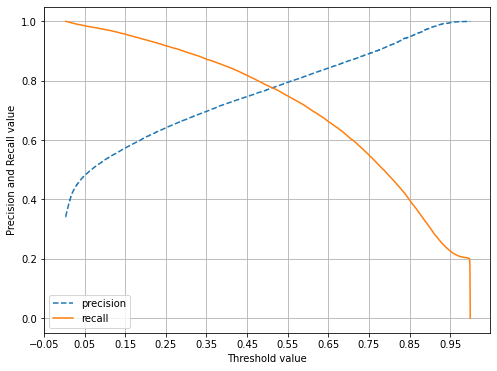

In [95]:
#로지스틱 회귀를 이용해 학습 및 val 예측
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,precision_recall_curve


# get_clf_eval(Y_val, lr_pred_val, lr_pred_proba[:,1])

lr_pred_proba_test = model.predict_proba(X_test)
lr_pred_proba = model.predict_proba(X_val)


lr_pred_train = model.predict(X_train)
lr_pred_val = model.predict(X_val)
lr_pred_test = model.predict(X_test)


#train 모델 정확도
print('# training model')
print('training accuracy: {0:.4f}'.format(accuracy_score(Y_train, lr_pred_train)))
print(confusion_matrix(Y_train, lr_pred_train))

#validation 모델 정확도
print('# validation model')
print('validation accuracy: {0:.4f}'.format(accuracy_score(Y_val, lr_pred_val)))
print(confusion_matrix(Y_val, lr_pred_val))

#test 모델 정확도
print('# test model')
print('test accuracy: {0:.4f}'.format(accuracy_score(Y_test, lr_pred_test)))
print(confusion_matrix(Y_test, lr_pred_test))


#validation set 평가
print('=========================================================================')
print(' #train VS val')

roc_curve_plot(Y_val, lr_pred_proba[:, 1])

#test set 평가


print('test accuracy: {0:.4f}'.format(accuracy_score(Y_test, lr_pred_test)))
print(confusion_matrix(Y_test, lr_pred_test))


#validation set 평가
print('=========================================================================')
print(' #train VS val')

roc_curve_plot(Y_val, lr_pred_proba[:, 1])

#test set 평가


print('=========================================================================')
print('# train VS test')
get_clf_eval(Y_test, lr_pred_test, lr_pred_proba_test[:,1])
roc_curve_plot(Y_test, lr_pred_proba_test[:, 1])

precision_recall_curve_plot(Y_test, lr_pred_proba_test[:,1])

print('=========================================================================')
print('# train VS test')
get_clf_eval(Y_test, lr_pred_test, lr_pred_proba_test[:,1])
roc_curve_plot(Y_test, lr_pred_proba_test[:, 1])

precision_recall_curve_plot(Y_test, lr_pred_proba_test[:,1])

In [96]:
lgbm_estimator = model.best_estimator_
pred = lgbm_estimator.predict(X_test)
print('테스트데이터셑 정확도 : {0:.4f}'.format(accuracy_score(Y_test,pred)))


print('=====================')
pred = model.predict(X_test)
accuracy_score(Y_test,pred)

print('=====================')
import pickle
import joblib
joblib.dump(lgbm_estimator,'lgbm_model.pkl')

테스트데이터셑 정확도 : 0.8622


['lgbm_model.pkl']

In [97]:
pred = model.predict(X_test)
accuracy_score(Y_test,pred)

0.8622375451743787

In [98]:
temp = model.best_estimator_

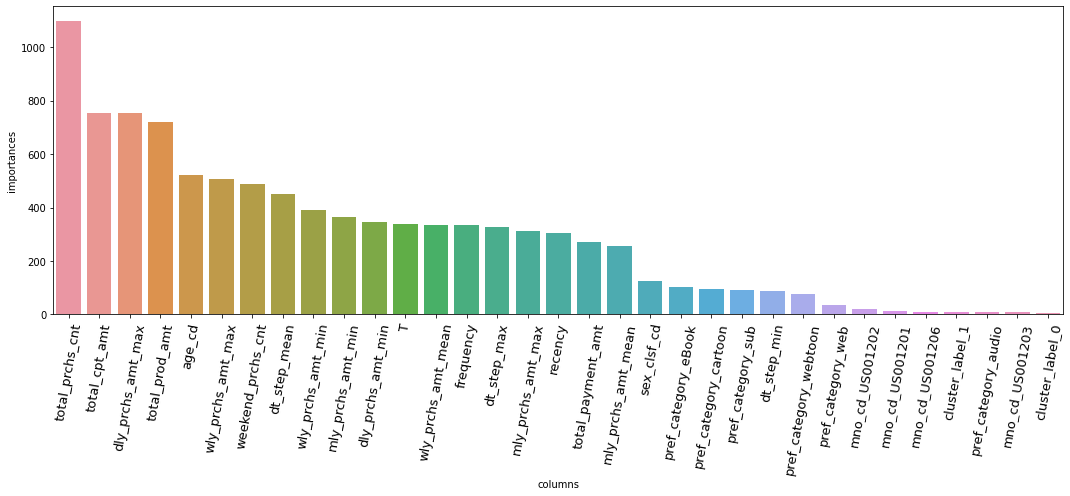

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

importance = temp.feature_importances_
df_fi = pd.DataFrame({'columns':cust2345.drop(['bin_count'], axis=1).columns[:], 'importances':importance})
df_fi = df_fi[df_fi['importances'] > 0] # importance가 0이상인 것만 
df_fi = df_fi.sort_values(by=['importances'], ascending=False)

fig = plt.figure(figsize=(15,7))
ax = sns.barplot(df_fi['columns'], df_fi['importances'])
ax.set_xticklabels(df_fi['columns'], rotation=80, fontsize=13)
plt.tight_layout()
plt.show()